In [68]:
# Import required libraries
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [69]:
# Load preprocessed data
with open('processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
scalers = data['scalers']
feature_columns = data['feature_columns']

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (1320, 60, 10)
Testing shape: (331, 60, 10)


In [70]:
# Increased capacity model with better regularization
model = Sequential([
    # First CNN block with more filters
    Conv1D(256, 5, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),  # Increased dropout
    
    # Second CNN block with more filters
    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.2),  # Increased dropout
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),  # Increased dropout
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

# Lower learning rate and add learning rate scheduling
optimizer = Adam(learning_rate=0.0001)  # Reduced from 0.0003

model.compile(optimizer=optimizer,
             loss='mse',
             metrics=['mae'])

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,  # Reduced from 64
    callbacks=[early_stopping],
    verbose=1
)

model.summary()

Epoch 1/150


C:\Users\dogwa\anaconda3\envs\Python_AI\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.3922 - mae: 0.9313 - val_loss: 0.5573 - val_mae: 0.7429
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5498 - mae: 0.5789 - val_loss: 0.8719 - val_mae: 0.9302
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3727 - mae: 0.4789 - val_loss: 0.8360 - val_mae: 0.9097
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2898 - mae: 0.4207 - val_loss: 0.8970 - val_mae: 0.9427
Epoch 5/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2052 - mae: 0.3579 - val_loss: 0.5070 - val_mae: 0.7078
Epoch 6/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1966 - mae: 0.3476 - val_loss: 0.5738 - val_mae: 0.7536
Epoch 7/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1774 - mae: 0.3202 - val_loss: 0.5624 - val_mae: 0.7463
Epoch 8/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1417 - mae: 0.2825 - val_loss: 0.4861 - val_mae: 0.6933
Epoch 9/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1432 -

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 60, 256)        │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 60, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │     1,966,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,288,645 (23.99 MB)

 Trainable params: 2,095,745 (7.99 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 4,191,492 (15.99 MB)

In [71]:
# Evaluate model
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_test_orig = scalers[1].inverse_transform(y_test)
y_pred_orig = scalers[1].inverse_transform(y_pred)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print("\nModel Performance Metrics:")
print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"R-squared Score (R²): {r2:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Model Performance Metrics:
Root Mean Square Error (RMSE): $8.32
Mean Absolute Error (MAE): $6.91
R-squared Score (R²): 0.8198


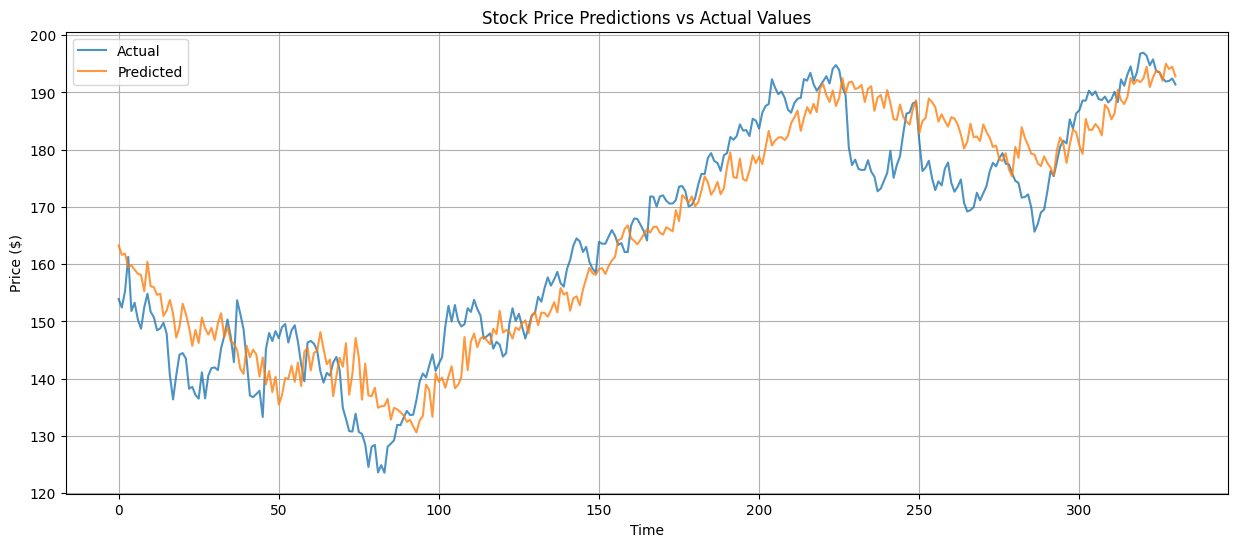

In [66]:
# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test_orig, label='Actual', alpha=0.8)
plt.plot(y_pred_orig, label='Predicted', alpha=0.8)
plt.title('Stock Price Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

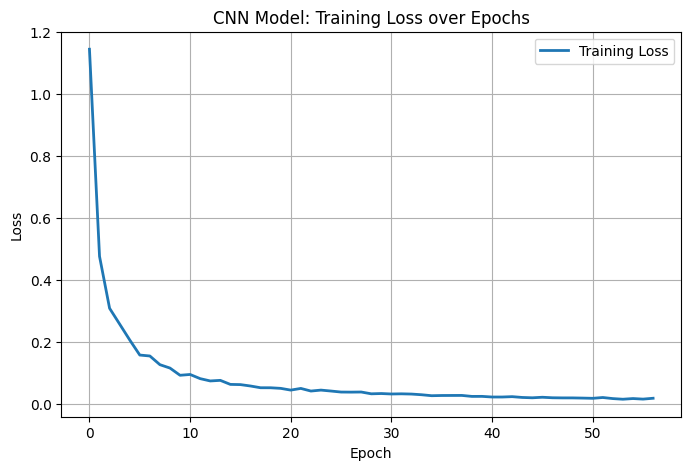

In [67]:
# Plot Training Loss vs Epochs for CNN Model

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.title('CNN Model: Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()